In [1]:
#Import requird libraries

import numpy as np
import pandas as pd
from pandas import Series

import  matplotlib.pyplot  as  plt
import  statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.tsa.api as smt
%matplotlib inline

In [53]:
data = pd.read_csv('data/predice-el-futuro/train_csv.csv', header = 0, index_col = 1, parse_dates = True, squeeze = True)
data.drop(['id'],axis = 1,inplace = True)
data.head()

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70


In [26]:
#Splitting data to Test:Train
train = data[0:int(len(data)*0.7)] 
test = data[int(len(data)*0.7):]

In [27]:
# extract out the time-series
feature_ts_train =  train['feature']
feature_ts_test =  test['feature']

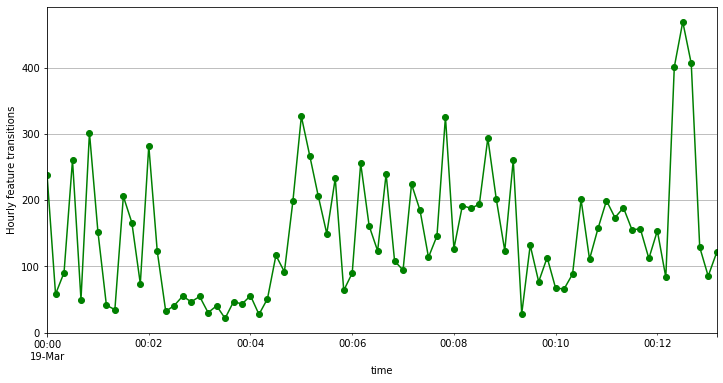

In [30]:
plt.figure(figsize=(12,6))
ax = data.loc[data.index, 'feature'].plot(marker='o', linestyle='-', color='g')
ax.set_ylabel('Hourly feature transitions');
ax.grid(True)

<Figure size 864x576 with 0 Axes>

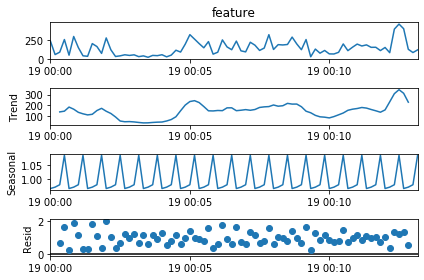

In [29]:
plt.figure(figsize=(12,8))
Pred = sm.tsa.seasonal_decompose(data.feature, model="multiplicative", freq=4)
Pred.plot()
plt.show()

<h2>Perform ARIMA on this dataset </h2> <br>
Perform Dicky Fuller Test on the timeseries <br>
Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [33]:
dicky_test = adfuller(feature_ts_train)
dicky_test
print('Dicky test statistic is : %3.3f' %dicky_test[0])
print('Dicky test p-value is : %1.4f' %dicky_test[1])

Dicky test statistic is : -2.019
Dicky test p-value is : 0.2782


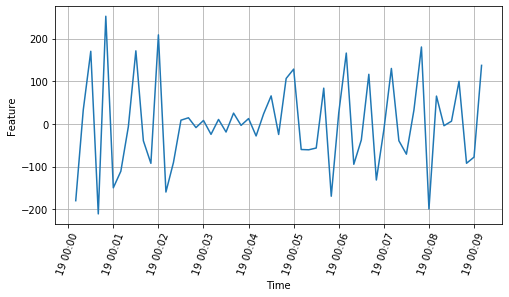

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(feature_ts_train.diff(periods=1))
plt.xlabel('Time')
plt.ylabel('Feature')
plt.xticks(rotation=70)
plt.grid(True)

In [37]:
feature_ts_train_diff = feature_ts_train.diff(periods=1)
feature_ts_train_diff.dropna(inplace=True)

feature_ts_test_diff = feature_ts_test.diff(periods=1)
feature_ts_test_diff.dropna(inplace=True)

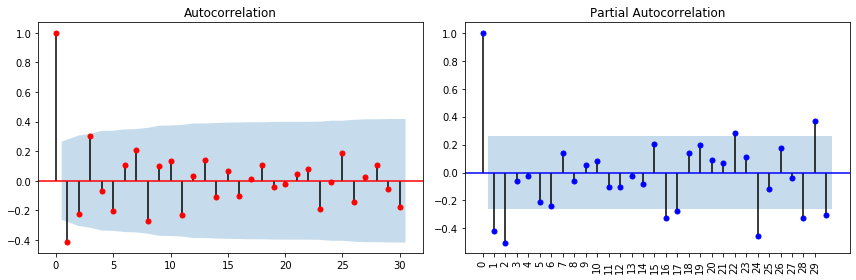

In [40]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(feature_ts_train_diff, lags=30, ax=axes[0], color='r')
smt.graphics.plot_pacf(feature_ts_train_diff, lags=30, ax=axes[1], color='b')
plt.tight_layout()

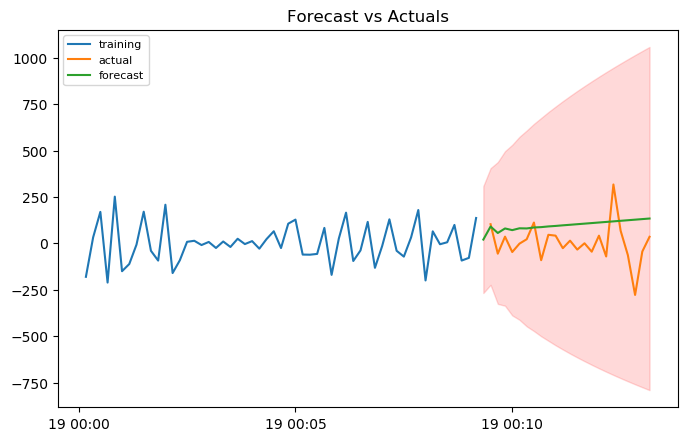

In [42]:
# Build Model 
model = ARIMA(feature_ts_train_diff, order=(1, 1, 0)) 
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(feature_ts_train_diff, label='training')
plt.plot(feature_ts_test_diff, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='r', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
forecast = fitted.forecast(steps=40)[0]
data_to_pred = pd.read_csv('data/predice-el-futuro/test_csv.csv')
data_to_pred['forecast'] = forecast
data_to_pred.head()

,id,time,forecast
0,80,2019-03-19 00:13:20,20.873633
1,81,2019-03-19 00:13:30,91.167614
2,82,2019-03-19 00:13:40,56.369452
3,83,2019-03-19 00:13:50,80.752181
4,84,2019-03-19 00:14:00,71.808177


In [47]:
data_to_pred.to_excel("Forecast_Prediction.xlsx")  